In [2]:
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from itertools import permutations
from sklearn.ensemble import AdaBoostClassifier


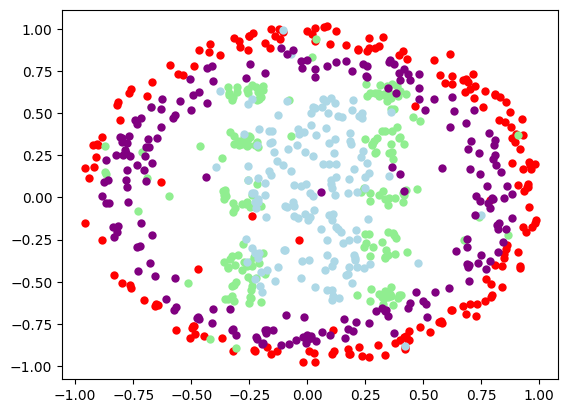

In [3]:
file = open('./train.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X = np.ndarray((0, 2))
y = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
    i += 1
    X = np.vstack((X, np.array(row[0:2])))
    y = np.append(y, y_mapping[row[2]])
X = X.astype(float)
y = y.astype(float)
file.close()

plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Bob', c='red', linewidths=0)
plt.scatter(
    X[y == 1, 0], X[y == 1, 1], label='Kate', c='lightgreen', linewidths=0)
plt.scatter(
    X[y == 2, 0], X[y == 2, 1], label='Mark', c='lightblue', linewidths=0)
plt.scatter(X[y == 3, 0], X[y == 3, 1], label='Sue', c='purple', linewidths=0)

In [4]:
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

X_train = train_data.drop(columns=['Competitor']).values
y_train = train_data['Competitor'].map(y_mapping).values
X_test = test_data.drop(columns=['Competitor']).values
y_test = test_data['Competitor'].map(y_mapping).values

## Voting


In [5]:
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', LogisticRegression(C=10, random_state=0)]])
pipe2 = Pipeline([['clf', DecisionTreeClassifier(max_depth=3, random_state=0)]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_neighbors=5)]])
pipe4 = Pipeline([['sc', StandardScaler()], ['clf', SVC(kernel='rbf', random_state=0, gamma=0.5, C=1000.0,probability=True)]])


clf = VotingClassifier(estimators=[('svm', pipe4), ('dt', pipe2), ('knn', pipe3)], voting='soft')

param_grid = {'weights':list(permutations([1, 2, 3, 4], 3))}
gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5)
gs.fit(X_train, y_train)
clf = gs.best_estimator_

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

vote_train = accuracy_score(y_train, y_train_pred) 
vote_test = accuracy_score(y_test, y_test_pred) 
print('[Voting]')
print('Accuracy : train = %.3f, test = %.3f' % (vote_train, vote_test))

[Voting]
Accuracy : train = 0.909, test = 0.838


## Bagging

In [ ]:
cv = KFold(n_splits=10, shuffle=True, random_state=0)

tree = DecisionTreeClassifier(criterion='entropy', random_state=0)
bagging = BaggingClassifier(base_estimator=tree, random_state=0)

param_gird = {'base_estimator__max_depth': range(1,5),
              'n_estimators': [50, 250, 500, 750],
              'max_samples': [0.2,0.5,0.7]}
gs = GridSearchCV(estimator=bagging, param_grid=param_gird,
                  scoring='accuracy', cv=cv, n_jobs=-1)
gs.fit(X_train, y_train)

In [7]:
print('best params', gs.best_params_)

best params {'base_estimator__max_depth': 4, 'max_samples': 0.2, 'n_estimators': 750}


In [8]:
print('[Bagging Classifier]')
print('Accuracy : train = %.3f, test = %.3f' %
      (gs.score(X_train, y_train), gs.score(X_test, y_test)))

[Bagging Classifier]
Accuracy : train = 0.835, test = 0.795


##  boosting

In [9]:
tree_stump = DecisionTreeClassifier(criterion='entropy', max_depth=1)

ada_stump = AdaBoostClassifier(base_estimator=tree_stump, n_estimators=500)
ada_stump = ada_stump.fit(X_train, y_train)
y_train_pred = ada_stump.predict(X_train)
y_test_pred = ada_stump.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('[AdaBoost with decision tree = depth 1]')
print('Accuracy train = %.3f, test = %.3f' % (ada_train, ada_test))

[AdaBoost with decision tree = depth 1]
Accuracy train = 0.676, test = 0.665


In [11]:
tree_deep = DecisionTreeClassifier(criterion='entropy')
ada_deep = AdaBoostClassifier(base_estimator=tree_deep, n_estimators=500)

param_grid = {'base_estimator__max_depth':range(11,17)}

gs = GridSearchCV(estimator=ada_deep, param_grid=param_grid, scoring='accuracy', cv=cv)
gs.fit(X_train, y_train)
ada_deep = gs.best_estimator_

y_train_pred = ada_deep.predict(X_train)
y_test_pred = ada_deep.predict(X_test)
ada_deep_train = accuracy_score(y_train, y_train_pred)
ada_deep_test = accuracy_score(y_test, y_test_pred)

print('[AdaBoost with decision tree with higher depths]')
print('Accuracy train = %.3f, test = %.3f' % (ada_deep_train, ada_deep_test))

[AdaBoost with decision tree with higher depths]
Accuracy train = 1.000, test = 0.708


## Evaluate and summarize the results  
我總共試了voting, bagging和boosting三種方式且每個都用Gridsearch來找到比較好的parameter，其中在adaboost用higher depths會比depth=1來的好。最後的結果顯示這三個之中最好的是Voting有著test accuracy = 0.838